In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from fastai import *
from fastai.text import *

import re
import sentencepiece as spm #https://github.com/google/sentencepiece

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [4]:
PATH = Path('/home/farzin/rnn_python_code/wiki103_from_download')

In [5]:
all_texts_df = pd.read_csv('/home/farzin/fast_ai/fastai_v1/courses/dl2/imdb_scripts/data/wiki/en/train.csv',sep='%$#')

/home/farzin/anaconda3/envs/fastaiv1_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
all_texts = all_texts_df.values.squeeze()

In [7]:
#all_texts = np.concatenate([train_texts,valid_texts])
idx = np.random.permutation(len(all_texts))
cut = int(0.1 * len(idx))
train_df = pd.DataFrame({'text':all_texts[idx[cut:]], 'labels':[0] * (len(all_texts)-cut)}, columns=['labels','text'])
valid_df = pd.DataFrame({'text':all_texts[idx[:cut]], 'labels':[0] * cut}, columns=['labels','text'])

train_df = train_df.dropna()
valid_df = valid_df.dropna()

### Sentence Piece expects some extra tokens

In [8]:
spec_char_cleaned = train_df['text']
train_df['new_text'] = '<s>' +spec_char_cleaned + '</s>'        

In [9]:
train_df['new_text'].head()

0    <s>It is analogous to the classifying space fo...
1    <s>The above agency keeps a record of the samp...
2                       <s>Chettikulangara Temple.</s>
3                                    <s>"KQIK (AM)</s>
4    <s>Gordon Henry(born 1955) is a poet and ficti...
Name: new_text, dtype: object

Save the file down so we can call the SWIG wrapped sentencepice app

In [10]:
formatted_text_file = 'wk103_text_download'

In [11]:
train_df['new_text'].to_frame().to_csv(formatted_text_file, header=False,index=False,quotechar=' ')

### SentencePiece tokenizer wrapped appropriately

In [12]:
# m.model and m.vocab created in the pwd
vocab_size = 60000
model_prefix = 'wk103m'

In [ ]:
spm.SentencePieceTrainer.Train(f'--input={formatted_text_file}'\
                               f' --model_prefix={model_prefix}'\
                               f' --vocab_size={vocab_size}')
#                               f'--unk_piece={UNK} --bos_piece={BOS} --eos_id=-1 --pad_piece={PAD}')

In [15]:
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [14]:
#Head of the Vocab file: Line nums indicate index of vocab
!head -n130 {model_prefix}.vocab | nl

     1	<unk>	0
     2	<s>	0
     3	</s>	0
     4	▁	-2.56885
     5	▁the	-3.10592
     6	,	-3.32733
     7	.	-3.3329
     8	▁of	-3.71478
     9	▁and	-3.85433
    10	▁in	-3.99789
    11	▁to	-4.19052
    12	s	-4.20986
    13	▁a	-4.22267
    14	▁was	-4.70678
    15	-	-4.87169
    16	▁""	-4.91273
    17	▁is	-4.97553
    18	""	-5.03327
    19	'	-5.10017
    20	▁for	-5.12424
    21	▁on	-5.21511
    22	▁as	-5.2155
    23	▁with	-5.28584
    24	▁by	-5.29711
    25	▁(	-5.38431
    26	▁The	-5.46781
    27	▁that	-5.48019
    28	▁from	-5.60573
    29	▁at	-5.62022
    30	"	-5.63823
    31	▁his	-5.70481
    32	The	-5.71977
    33	▁he	-5.89781
    34	▁an	-5.91009
    35	)	-5.93896
    36	▁were	-6.09722
    37	▁are	-6.11352
    38	▁which	-6.13554
    39	▁it	-6.18178
    40	▁be	-6.26719
    41	▁He	-6.29722
    42	▁also	-6.33058
    43	▁had	-6.36613
    44	▁has	-6.38715
    45	:	-6.41574
    46	▁In	-6.42317
    47	▁or	-6.43654
    48	▁first	-6.46217
    49	▁their	-6.54619
    50	In	-6.56
    51	▁not	-6.62

In [16]:
## itos from m.vocab file: just read directly and populate the dictionary
itos = {}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos[line_num] = line.split("\t")[0]
        
stoi = {v:k for k,v in itos.items()}

In [17]:
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,sp_processor,replace_dict=None,n_cpus=None):
        self.sp = sp_processor
        self.replace_dict = replace_dict
        self.n_cpus = n_cpus or num_cpus()//2        
        
    def __repr__(self) -> str:
        return "Custom Tokenizer"

    def process_text(self, t:str) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."  
        if self.replace_dict is not None:
            t = find_replace_python_str(t,self.replace_dict)        
        toks = sp.EncodeAsIds(t)
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        return [self.process_text(t) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [19]:
mycust_tok = CustomTokenizer(sp,n_cpus=2)

In [20]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

### build LM from tokenizer and Vocab

In [21]:
data = TextLMDataBunch.from_df(PATH, train_df, valid_df, 
                               tokenizer=mycust_tok, vocab=sp_vocab, 
                               text_cols='text', label_cols='labels')

In [22]:
os.makedirs(PATH/'sp_tokenizer', exist_ok=True)

In [23]:
data.save(cache_name=PATH/'sp_tokenizer')

In [24]:
!ls -lhart {PATH}/'sp_tokenizer'

total 1.3G
drwxrwxr-x 5 farzin farzin 4.0K Jan 17 13:37 ..
-rw-rw-r-- 1 farzin farzin 1.3M Jan 17 13:37 itos.pkl
-rw-rw-r-- 1 farzin farzin 1.2G Jan 17 13:37 train_ids.npy
-rw-rw-r-- 1 farzin farzin  20M Jan 17 13:37 train_lbl.npy
-rw-rw-r-- 1 farzin farzin 130M Jan 17 13:38 valid_ids.npy
-rw-rw-r-- 1 farzin farzin 2.2M Jan 17 13:38 valid_lbl.npy
-rw-rw-r-- 1 farzin farzin    2 Jan 17 13:38 classes.txt
drwxrwxr-x 2 farzin farzin 4.0K Jan 17 13:38 .


In [16]:
from fastai.text.data import _get_processor
my_processor = _get_processor(mycust_tok,sp_vocab)
data = TextLMDataBunch.load(path=PATH,cache_name='sp_tokenizer',processor=my_processor)

In [28]:
#data.batch_size = 16
bptt = 140
emb_sz,nh,nl = 400,1111,4

learn = language_model_learner(data,bptt,emb_sz,nh,nl,drop_mult=0.5,qrnn=True)
learn.unfreeze()
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=800, out_features=3333, bias=True)
        )
      )
      (1): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=3333, bias=True)
        )
      )
      (2): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=3333, bias=True)
        )
      )
      (3): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=1200, bias=True)
        )
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
      (3): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Li

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


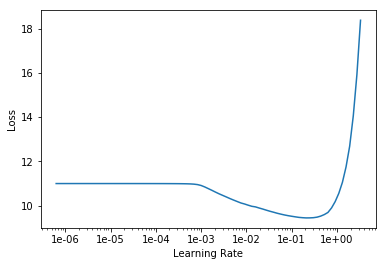

In [26]:
lr_find(learn)
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7), wd=0.03, pct_start=0.25)

epoch,train_loss,valid_loss,accuracy
1,4.924659,4.793722,0.279016
2,4.782756,4.640035,0.289717
3,4.515332,4.385171,0.309784
4,4.379240,4.227416,0.325146


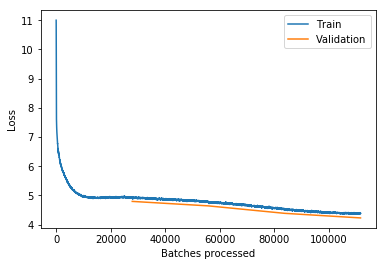

In [30]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy
1,4.560749,4.421819,0.307159
2,4.811614,4.675819,0.286210
3,4.854005,4.706613,0.284898
4,4.802364,4.670103,0.287742
5,4.743124,4.603476,0.292810
6,4.651075,4.512500,0.299381
7,4.536386,4.401228,0.307731
8,4.437648,4.287876,0.318629
9,4.367714,4.187848,0.328665
10,4.322928,4.153242,0.332537


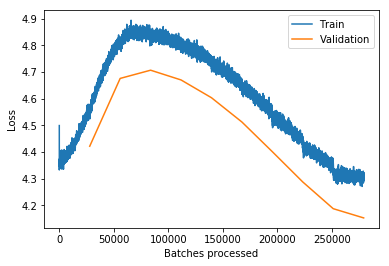

In [31]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7), wd=0.03, pct_start=0.25)
learn.recorder.plot_losses()

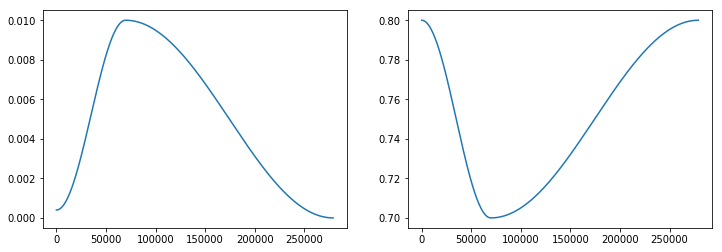

In [33]:
learn.recorder.plot_lr(show_moms=True)

In [34]:
learn.fit_one_cycle(4, 1e-2/4, moms=(0.95,0.8), wd=0.03, pct_start=0.15)

epoch,train_loss,valid_loss,accuracy
1,4.459930,4.314294,0.316137
2,4.406609,4.247024,0.322286
3,4.326707,4.158190,0.331646
4,4.269075,4.117231,0.336263


In [35]:
np.exp(4.117)

61.374841277416465

In [36]:
learn.save("wiki103_raw_articles_sentencepiece_20190123")
learn.save_encoder('wiki103_sp_enc')